# Setup ion to pathway transformation data from HMDB
 This program will fetch the current HMDB and generate the ion2pathway participation matrix for all annotated ions in HMDB4_neg_Honly_1mD_allNames.csv'
You will need to download HMDB's huge xml file for all compounds here and unzip the file: ['hmdb_metabolites.zip'](https://hmdb.ca/system/downloads/current/hmdb_metabolites.zip)

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from scipy import stats
from IPython.display import display

from io import StringIO
from lxml import etree
import csv
import re

In [2]:
#konstants
hmdb_clear_cache = False #reprocess the downloaded and unzipped HMDB xml file 

#pathway coverage score
pscore = 3.00

In [3]:
#define a function to extract information for HMDB compounds

def hmdbextract(name, file):
    ns = {'hmdb': 'http://www.hmdb.ca'}
    context = etree.iterparse(name, tag='{http://www.hmdb.ca}metabolite')
    csvfile = open(file, 'w')
    fieldnames = ['accession',
                  'secondary_accessions',
                  'monisotopic_molecular_weight', 
                  'iupac_name', 
                  'name', 
                  'chemical_formula', 
                  'InChIKey', 
                  #'cas_registry_number', 
                  #'smiles', 
                  #'drugbank',
                  #'chebi_id', 
                  #'pubchem', 
                  #'phenol_explorer_compound_id',
                  #'food',
                  #'knapsack', 
                  #'chemspider', 
                  #'kegg', 
                  #'meta_cyc',
                  #'bigg',
                  #'metlin_id',
                  #'pdb_id', 
                  #'logpexp',
                  'kingdom',  
                  'direct_parent', 
                  'super_class', 
                  'class', 
                  'sub_class', 
                  'molecular_framework',
                  'pathways'
                 ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for event, elem in context:
        accession = elem.xpath('hmdb:accession/text()', namespaces=ns)[0]
        try:
            monisotopic_molecular_weight = elem.xpath('hmdb:monisotopic_molecular_weight/text()', namespaces=ns)[0]
        except:
            monisotopic_molecular_weight = 'NA'
        try:
            iupac_name = elem.xpath('hmdb:iupac_name/text()', namespaces=ns)[0]#.encode('utf-8')
        except:
            iupac_name = 'NA'
        name = elem.xpath('hmdb:name/text()', namespaces=ns)[0]#.encode('utf-8')
        try:
            chemical_formula = elem.xpath('hmdb:chemical_formula/text()', namespaces=ns)[0]
        except:
            chemical_formula = 'NA'
        try:
            inchikey = elem.xpath('hmdb:inchikey/text()', namespaces=ns)[0]
        except:
            inchikey = 'NA'
            
            
            
        """    
        try:
            cas_registry_number = elem.xpath('hmdb:cas_registry_number/text()', namespaces=ns)[0]
        except:
            cas_registry_number = 'NA'
        try:
            smiles = elem.xpath('hmdb:smiles/text()', namespaces=ns)[0]
        except:
            smiles = 'NA'
        try:
            drugbank = elem.xpath('hmdb:drugbank_id/text()', namespaces=ns)[0]
        except:
            drugbank = 'NA'
        try:
            chebi_id = elem.xpath('hmdb:chebi_id/text()', namespaces=ns)[0]
        except:
            chebi_id = 'NA'
        try:
            pubchem = elem.xpath('hmdb:pubchem_compound_id/text()', namespaces=ns)[0]
        except:
            pubchem = 'NA'
        try:
            phenol_explorer_compound_idt = elem.xpath('hmdb:phenol_explorer_compound_id/text()', namespaces=ns)[0]
        except:
            phenol_explorer_compound_id = 'NA'
        try:
            food = elem.xpath('hmdb:foodb_id/text()', namespaces=ns)[0]
        except:
            food = 'NA'
        try:
            knapsack = elem.xpath('hmdb:knapsack_id/text()', namespaces=ns)[0]
        except:
            knapsack = 'NA'
        try:
            chemspider = elem.xpath('hmdb:chemspider_id/text()', namespaces=ns)[0]
        except:
            chemspider = 'NA'
        try:
            kegg = elem.xpath('hmdb:kegg_id/text()', namespaces=ns)[0]
        except:
            kegg = 'NA'
        try:
            meta_cyc = elem.xpath('hmdb:meta_cyc_id/text()', namespaces=ns)[0]
        except:
            meta_cyc = 'NA'
        try:
            bigg = elem.xpath('hmdb:bigg_id/text()', namespaces=ns)[0]
        except:
            bigg = 'NA'
        try:
            metlin_id = elem.xpath('hmdb:metlin_id/text()', namespaces=ns)[0]
        except:
            metlin_id = 'NA'
        try:
            pdb_id = elem.xpath('hmdb:pdb_id/text()', namespaces=ns)[0]
        except:
            pdb_id = 'NA'
        try:
            logpexp = elem.xpath('hmdb:experimental_properties/hmdb:property[hmdb:kind = "logp"]/hmdb:value/text()', namespaces=ns)[0]
        except:
            logpexp = 'NA'
         """   
            
            
        try:
            kingdom = elem.xpath('hmdb:taxonomy/hmdb:kingdom/text()', namespaces=ns)[0]
        except:
            kingdom = 'NA'
        try:
            direct_parent = elem.xpath('hmdb:taxonomy/hmdb:direct_parent/text()', namespaces=ns)[0]
        except:
            direct_parent = 'NA'
        try:
            super_class = elem.xpath('hmdb:taxonomy/hmdb:super_class/text()', namespaces=ns)[0]
        except:
            super_class = 'NA'
        try:
            classorg = elem.xpath('hmdb:taxonomy/hmdb:class/text()', namespaces=ns)[0]
        except:
            classorg = 'NA'
        try:
            sub_class = elem.xpath('hmdb:taxonomy/hmdb:sub_class/text()', namespaces=ns)[0]
        except:
            sub_class = 'NA'
        try:
            molecular_framework = elem.xpath('hmdb:taxonomy/hmdb:molecular_framework/text()', namespaces=ns)[0]
        except:
            molecular_framework = 'NA'
        #secondary accessions
        try: 
            secondary_accessions = elem.xpath('hmdb:secondary_accessions/hmdb:accession/text()', namespaces=ns)
            secondary_accessions = ";".join(secondary_accessions) #make list into semicolon separated string
        except:
            pathways = 'NA'
        #pathways
        try: 
            pathways = elem.xpath('hmdb:biological_properties/hmdb:pathways/hmdb:pathway/hmdb:name/text()', namespaces=ns)
            pathways = ";".join(pathways) #make list into semicolon separated string
        except:
            pathways = 'NA'

        writer.writerow({'accession': accession,
                         'secondary_accessions': secondary_accessions,
                         'monisotopic_molecular_weight': monisotopic_molecular_weight, 
                         'iupac_name': iupac_name, 
                         'name': name, 
                         'chemical_formula': chemical_formula, 
                         'InChIKey': inchikey, 
                         #'cas_registry_number': cas_registry_number, 
                         #'smiles': smiles,
                         #'drugbank': drugbank,
                         #'chebi_id': chebi_id,
                         #'pubchem': pubchem,
                         #'phenol_explorer_compound_id':phenol_explorer_compound_id, 
                         #'food': food,
                         #'knapsack': knapsack, 
                         #'chemspider': chemspider,
                         #'kegg': kegg, 
                         #'meta_cyc': meta_cyc, 
                         #'bigg':bigg, 
                         #'metlin_id': metlin_id, 
                         #'pdb_id':pdb_id,
                         #'logpexp':logpexp, 
                         'kingdom': kingdom, 
                         'direct_parent': direct_parent, 
                         'super_class': super_class, 
                         'class': classorg, 
                         'sub_class': sub_class, 
                         'molecular_framework': molecular_framework,
                         'pathways': pathways
                        })
        # It's safe to call clear() here because no descendants will be
        # accessed
        elem.clear()
        # Also eliminate now-empty references from the root node to elem
        for ancestor in elem.xpath('ancestor-or-self::*'):
            while ancestor.getprevious() is not None:
                del ancestor.getparent()[0]
    del context
    return;

In [4]:
#where to find hmdb.xml input file
infile = os.path.join('data', 'hmdb_metabolites.xml')

#where to find hmdb.csv output file
outfile = os.path.join('data', 'hmdb.csv')

#clear the hmdb chached data if desired
if hmdb_clear_cache:
    if os.path.exists(outfile):
        os.remove(outfile)

#Run the hmdb extract function on the unzipped xml file if the csv is missing
if not os.path.exists(outfile):
    #assert unzipped xml file exists
    assert(os.path.exists(infile))
    #extract xml data
    hmdbextract(infile, outfile)

# load the cached hmdb data as a dataframe
hmdb_df = pd.read_csv(outfile, low_memory=False)

In [5]:
#get ion annotations as a dataframe
annot_df = pd.read_csv(os.path.join('data', 'HMDB4_neg_Honly_1mD_allNames.csv'))

#display(annot_df)

In [6]:
#init a df of annotations with pathways
i2p_df = pd.DataFrame(columns=['hmdb', 'name', 'formula', 'ion', 'pathways'])

#init set of unique pathways
upaths = set()

#Loop over annotations
for idx, annot in annot_df.iterrows():
    #get IDs as list
    ids = annot.id.split(';')
    #get valid HMDB ids
    ids = [id.strip() for id in ids if "HMDB" in id]
    #loop over ids
    for id in ids:
        #regex for the HMDBid followed by semicolon or end of string - use matching group notation (?:) 
        regex = id + '(?:;|$)' 
        #get location in hmdb_df where the id appears
        rows = hmdb_df.loc[hmdb_df.accession.str.contains(regex) | 
                           hmdb_df.secondary_accessions.str.contains(regex)]

        #assert no more than 1 row is found
        assert(len(rows)<=1)
        
        if len(rows)==1:
            #display(id)
            #display(list(rows.secondary_accessions))
            pathways = rows.pathways.iloc[0]
            
            #append to i2p_df if pathways are found
            if isinstance(pathways, str):
                #get pathways as semicolon sep list and add to set of unique pathways
                for pathway in pathways.split(';'):
                    upaths.add(pathway)
                hmdb=rows.accession.iloc[0]
                name=str(rows.name.iloc[0])
                formula=rows.chemical_formula.iloc[0]
                i2p_df.loc[len(i2p_df), i2p_df.columns] = hmdb, name, formula, annot.ion, pathways
                
    if idx%500==0:
        print(idx, idx/len(annot_df))
        

0 0.0
500 0.04942665085013839
1000 0.09885330170027679
1500 0.14827995255041518
2000 0.19770660340055357
2500 0.24713325425069196
3000 0.29655990510083036
3500 0.3459865559509688
4000 0.39541320680110714
4500 0.44483985765124556
5000 0.4942665085013839
5500 0.5436931593515223
6000 0.5931198102016607
6500 0.6425464610517991
7000 0.6919731119019376
7500 0.741399762752076
8000 0.7908264136022143
8500 0.8402530644523527
9000 0.8896797153024911
9500 0.9391063661526295
10000 0.9885330170027679


In [7]:
#remove duplicate hmdb ion pairs caught by secondary accession numbers
i2p_df = i2p_df.drop_duplicates()

#save annotation dataframe
i2p_df.to_csv(os.path.join('data','i2p_df.csv'), index=False)

#remove annotations
del annot_df


In [8]:
#init membership matrix
memb_df = pd.DataFrame(0, index=i2p_df.index, columns=list(upaths))

#loop over upaths
for ipath, pathway in enumerate(memb_df.columns):
    #print(ipath, pathway)
    #regex for the HMDBid followed by semicolon or end of string - use matching group notation (?:) 
    regex = re.escape(pathway) + '(?:;|$)'
    
    #get location where path appears in pathways column
    rows = i2p_df.loc[i2p_df.pathways.str.contains(regex)]

    #set ion, pathway location to 1 for all ions in rows
    memb_df.loc[rows.index, pathway] = 1

    if ipath%1000==0:
        print(ipath, ipath/len(memb_df.columns))      

0 0.0
1000 0.02082335547550132
2000 0.04164671095100264
3000 0.06247006642650397
4000 0.08329342190200528
5000 0.10411677737750662
6000 0.12494013285300794
7000 0.14576348832850924
8000 0.16658684380401056
9000 0.1874101992795119
10000 0.20823355475501323
11000 0.22905691023051455
12000 0.24988026570601587
13000 0.2707036211815172
14000 0.2915269766570185
15000 0.31235033213251984
16000 0.33317368760802113
17000 0.3539970430835225
18000 0.3748203985590238
19000 0.3956437540345251
20000 0.41646710951002647
21000 0.43729046498552776
22000 0.4581138204610291
23000 0.4789371759365304
24000 0.49976053141203175
25000 0.5205838868875331
26000 0.5414072423630344
27000 0.5622305978385357
28000 0.583053953314037
29000 0.6038773087895384
30000 0.6247006642650397
31000 0.645524019740541
32000 0.6663473752160423
33000 0.6871707306915437
34000 0.707994086167045
35000 0.7288174416425462
36000 0.7496407971180477
37000 0.770464152593549
38000 0.7912875080690502
39000 0.8121108635445515
40000 0.83293421

In [9]:
#join HMDB name, formula, and ion number to membership matrix
memb_df = pd.concat([i2p_df[['hmdb', 'name', 'formula', 'ion']], memb_df], axis=1)

#remove annot_df
del i2p_df

In [10]:
# verification

#get location in where annotated metabolite name is adenine 
adenine_df = memb_df.loc[memb_df.name.str.lower()=='adenine']

# assert adenine is in the particiaption matrix
assert(len(adenine_df)>0)

# assert APRT pathway is in pathways
pathway = 'Adenine phosphoribosyltransferase deficiency (APRT)'
assert(pathway in memb_df.columns)

# assert every row in adenine df is associated with the APRT pathway
assert (adenine_df[pathway].sum()==len(adenine_df))

In [11]:
#collapse pathways that have identical sets of ions

def collapse_equiv_columns(df):
  
    #init output as an empty dict
    col_dict = dict()

    #init set of unchecked column names
    colnames = set(df.columns)
    
    #init diagnostic counter
    count = 0
    
    #do while unchecked column names remain
    while len(colnames)>1:
        
        #pop one column off the set to check
        icol = colnames.pop()

        # Create an empty set of columns that are the same as icolumn
        dups = set()
      
        # loop through remaining columns 
        for jcol in colnames:             
            # Check if columns are equal
            if df.loc[:, icol].equals(df.loc[:, jcol]):
                #add jth column name to set of duplicate columns
                dups.add(jcol)
       
        #if any duplicate columns were found
        if len(dups)>0:
            #drop duplicate columns from df
            df.drop(columns=list(dups), inplace=True)
            #append to dictionary mapping icol to the dups
            col_dict[icol] = list(dups)
            #remove duplicate columns from colnames set
            colnames = colnames - dups
            #break
                    
        #diagnostic output
        count += 1
        if count%100 ==0:
            print(len(colnames), len(df.columns))
                  
    # Return dict of equivalent columns
    return df, col_dict


In [12]:
memb_df, equiv_pathways_dict = collapse_equiv_columns(memb_df)

6465 6565
4224 4424
3165 3465
2397 2797
2060 2560
1821 2421
1622 2322
1490 2290
1370 2270
1248 2248
1120 2220
1017 2217
900 2200
797 2197
694 2194
591 2191
491 2191
391 2191
291 2191
189 2189
89 2189


In [13]:
#Save equivalent pathway dictionary
with open(os.path.join('data','eqiv_pathways.pkl'), 'wb') as handle:
    pickle.dump(equiv_pathways_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
#Save membership matrix
memb_df.to_csv(os.path.join('data','membership0.csv'), index = False, header=True)

In [15]:
with open('data/eqiv_pathways.pkl', 'rb') as handle:
    equiv_pathways_dict = pickle.load(handle)
memb_df = pd.read_csv(os.path.join('data','membership0.csv'))

In [16]:
#calculate over representation test for each pathway in membership matrix

#get pathways in membership matrix
pathways = memb_df.columns[4:]

#init dataframe to hold number of HMDB metabolites in each pathway, 
ort_df = pd.DataFrame(index = pathways, columns=['Np_hmdb'])

#init set of unique hmdb metabolites
umetabos = set()

#loop over pathways in membership matrix
for pathway in pathways:
    #regex for the pathway followed by semicolon or end of string - use matching group notation (?:) 
    regex = re.escape(pathway) + '(?:;|$)'
    #get location in hmdb_df where the pathway appears
    rows = hmdb_df.loc[hmdb_df.pathways.str.contains(regex, na=False)]
    #count number of HMDB metabolites in pathway
    ort_df.Np_hmdb.loc[ort_df.index==pathway] = len(rows)
    #update set of unique metabolites
    umetabos.update(rows.accession)

#count number of membership matrix metabolites in each pathway
ort_df['np_memb'] = memb_df.sum(axis=0)[4:]


In [17]:
#total metabolites in HMDB
N = len(umetabos)

#hmdb metabolites in pathway
Np = ort_df.Np_hmdb

#total metabolites in membership matrix
subn = ort_df.np_memb.sum()

#membership matrix metabolites in pathway
subnp = ort_df.np_memb

#Fisher 2x2 matrix [[a, b], [c, d]]
a = np.array(subnp).astype(float)
b = np.array(Np-subnp).astype(float)
c = np.array(subn-subnp).astype(float)
d = np.array(N-Np-subn+subnp).astype(float)

#Stirling's approximation
def lognfact(n):
    return n*np.log(n)-n

#calculate coverage fraction
ort_df['coverage']=subnp/Np

# calculate score
ort_df['neglogp']= ((lognfact(a) + lognfact(b) + lognfact(c) + lognfact(d) + lognfact(N))-
                    (lognfact(a+b) + lognfact(c+d) + lognfact(a+c) + lognfact(b+d))
                   )
ort_df['pvalue']= np.exp(-ort_df.neglogp)

#ort_df['Bonferroni_pval']= ort_df.pvalue*len(ort_df)

##calculate FDR correted pvalues
#def fdr(pvals):
#    """BH pvalue correction"""
#    ranked_pvals = stats.rankdata(pvals)
#    adj_pvals = pvals * len(pvals) / ranked_pvals
#    adj_pvals[adj_pvals > 1] = 1
#    return adj_pvals
#ort_df['FDR_pval']= fdr(ort_df.pvalue)

# score as coverage weighted nlogp
ort_df['score']=ort_df.coverage*ort_df.neglogp

display(ort_df)

#Save coverage weighted ORT df
ort_df.to_csv(os.path.join('data','pathwaycoverage.csv'), index = True, header=True)


/var/folders/v3/d9c1pzwx0ld7sf9x7_4wzy4c0000gq/T/ipykernel_65049/1813982511.py:21: RuntimeWarning: divide by zero encountered in log
  return n*np.log(n)-n
/var/folders/v3/d9c1pzwx0ld7sf9x7_4wzy4c0000gq/T/ipykernel_65049/1813982511.py:21: RuntimeWarning: invalid value encountered in multiply
  return n*np.log(n)-n


,Np_hmdb,np_memb,coverage,neglogp,pvalue,score
"De Novo Triacylglycerol Biosynthesis TG(20:3(5Z,8Z,11Z)/18:2(9Z,12Z)/18:3(6Z,9Z,12Z))",14,1,0.071429,28.589730,3.833874e-13,2.042124
"Cardiolipin Biosynthesis CL(a-13:0/a-21:0/18:2(9Z,11Z)/i-16:0)",20,2,0.1,38.201324,2.566705e-17,3.820132
Cardiolipin Biosynthesis CL(i-12:0/i-22:0/i-22:0/i-18:0),20,3,0.15,33.847472,1.996319e-15,5.077121
"De Novo Triacylglycerol Biosynthesis TG(18:1(11Z)/18:2(9Z,12Z)/22:2(13Z,16Z))",13,2,0.153846,21.741120,3.613697e-10,3.344788
"Cardiolipin Biosynthesis CL(16:0/16:0/22:5(7Z,10Z,13Z,16Z,19Z)/18:0)",18,2,0.111111,33.449471,2.972210e-15,3.716608
...,...,...,...,...,...,...
"Phosphatidylcholine Biosynthesis PC(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/18:1(11Z))",20,1,0.05,43.136073,1.846041e-19,2.156804
"De Novo Triacylglycerol Biosynthesis TG(24:1(15Z)/20:3(5Z,8Z,11Z)/18:2(9Z,12Z))",14,2,0.142857,24.058478,3.560703e-11,3.436925
"Phosphatidylcholine Biosynthesis PC(18:1(11Z)/18:3(9Z,12Z,15Z))",20,1,0.05,43.136073,1.846041e-19,2.156804
"De Novo Triacylglycerol Biosynthesis TG(18:1(9Z)/22:0/20:2(11Z,14Z))",12,2,0.166667,19.439509,3.610178e-09,3.239918


In [24]:
cutoff = 2*np.median(ort_df.score[ort_df.score>np.quantile(ort_df.score, 1/2)])
#print(cutoff)
#print(np.sum(ort_df.score>cutoff))
df = ort_df.loc[ort_df.score>cutoff].sort_values(by='score', axis=0, ascending=False)
display(df)




,Np_hmdb,np_memb,coverage,neglogp,pvalue,score
Azathioprine Action Pathway,88,27,0.306818,101.130767,1.200787e-44,31.028758
Mercaptopurine Action Pathway,86,26,0.302326,100.040228,3.573393e-44,30.24472
Ureidopropionase Deficiency,78,31,0.397436,67.602249,4.372364e-30,26.86756
Disulfiram Action Pathway,76,31,0.407895,63.563697,2.481060e-28,25.927297
Purine metabolism,73,23,0.315068,81.490821,4.064302e-36,25.67519
...,...,...,...,...,...,...
Carbamoyl Phosphate Synthetase Deficiency,27,12,0.444444,19.567644,3.175998e-09,8.696731
Fatty Acid Elongation In Mitochondria,35,5,0.142857,60.597336,4.818493e-27,8.656762
Mercaptopurine Metabolism Pathway,27,6,0.222222,38.220539,2.517856e-17,8.493453
Glycerolipid Metabolism,25,7,0.28,30.312528,6.845993e-14,8.487508


In [41]:
display(df.index.to_list()[60:78])

['Androgen and Estrogen Metabolism',
 'Nitrogen metabolism',
 'Phenylalanine and Tyrosine Metabolism',
 'Tay-Sachs Disease',
 'Oxidation of Branched Chain Fatty Acids',
 'Cysteine Metabolism',
 'Phospholipid Biosynthesis',
 'Urea Cycle',
 'Carbamoyl Phosphate Synthetase Deficiency',
 'Fatty Acid Elongation In Mitochondria',
 'Mercaptopurine Metabolism Pathway',
 'Glycerolipid Metabolism',
 'Phytanic Acid Peroxisomal Oxidation']

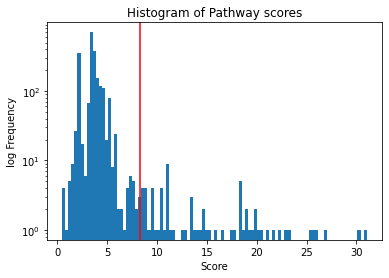

In [50]:
# An "interface" to matplotlib.axes.Axes.hist() method
ort_df.score.plot.hist(bins=100, log=True)
plt.axvline(cutoff, color='red')
#plt.xlim(pcut)
plt.xlabel('Score')
plt.ylabel('log Frequency')
plt.title('Histogram of Pathway scores')
plt.show()




In [ ]:
#select pathways with score above cutoff
drops = memb_df.columns[memb_df.columns.isin(ort_df.loc[ort_df.score<cutoff].index)]
memb_df.drop(columns=drops, inplace=True)

In [40]:
# look for APRT pathway is in pathways
pathway = 'Adenine phosphoribosyltransferase deficiency (APRT)'

# assume can't find the APRT pathway
test = False

if pathway in memb_df.columns:
    #APRT is explicitly named in the membership matrix
    test = True
else:
    #find equivalent pathway that contains the APRT pathway
    for key in equiv_pathways_dict:
        if pathway in equiv_pathways_dict[key]:
            print(key+ " <-is equivalent to-> "+pathway)
            test = True
            
# assert APRT pathway is represented in the final pathways
assert(test)

Adenosine Deaminase Deficiency <-is equivalent to-> Adenine phosphoribosyltransferase deficiency (APRT)


In [41]:
#generate unique pathways for metabolies with multiple ions representations

#number of memb_df book-keeping columns to skip
nskip=4

#init counter for new pathways created
pcount=0

#init by assuming duplicate metabolites exists
hasdups = True

#loop until no duplicated metabolites are found in any pathway
while hasdups:
    print("==================================================")
    print("Looping over current pathways Npath= "+str(len(memb_df.columns)-nskip))
    #assume duplicates don't exist for this round of pathways
    hasdups = False
    #loop over pathways (skip first book-keeping columns 'hmdb', 'name', 'formula', 'ion' in membership df)
    pathways = memb_df.columns[nskip:]
    for pathway in pathways:
        #select rows that participate
        rows = memb_df.loc[memb_df[pathway]==1]

        #get set of duplicated metabolites (hmdb ids)
        dups = set(rows.hmdb[rows.hmdb.duplicated(keep=False)])
        
        #determine if any duplicates were found for any pathway in this round
        if len(dups)>0:
            hasdups = True            
            
        #treat duplicate metabolites
        if len(dups)>0:
            #consider only the first duplicated metabolite at a time
            metabo = dups.pop()

            #init empty data frame to hold new pathways 
            df = memb_df[['ion', pathway]].copy()
            
            #get list of possible ions that represent the metabolite
            pions = rows.ion[rows.hmdb==metabo]
            names = rows.name[rows.hmdb==metabo]
            
            #init list of new pathways
            newpathways = list()
            
            #loop over possible ions
            for ion in pions:
                #increment new pathway counter
                pcount += 1
                
                #create new pathway for this ion representation
                newpathway = pathway+"_"+str(pcount)
                newpathways.append(newpathway)
                df[newpathway] = df[pathway].copy()

                #set all pions except for ion to 0 
                df.loc[(df['ion'].isin(pions)) & (df['ion']!=ion), newpathway] = 0

            #if new pathways were created
            if len(df.columns)>0:
                #concatenate the new pathways
                memb_df = pd.concat([memb_df, df[newpathways]], axis=1)
                #drop the original pathway now that the pions have been one-hot encoded
                memb_df.drop(columns=[pathway], inplace=True)


            #diagnostic print the current pathway and newpathway count
            print(pcount, list(names), list(pions), pathway)
            #display(pathway)
            #newpaths = list(memb_df.columns[memb_df.columns.str.contains(pathway)])
            #display(newpaths)
            #display(memb_df[['hmdb', 'name', 'formula', 'ion']+newpaths].loc[df[pathway]==1])
            #stop
                         
print('Done!')

Looping over current pathways Npath= 75
2 ['Oxoglutaric acid', 'Oxoglutaric acid'] [703, 733] Canavan Disease
4 ['Oxoglutaric acid', 'Oxoglutaric acid'] [703, 733] The Oncogenic Action of Fumarate
6 ['Oxoglutaric acid', 'Oxoglutaric acid'] [703, 733] Tyrosinemia, transient, of the newborn
8 ['Oxoglutaric acid', 'Oxoglutaric acid'] [703, 733] Nitrogen metabolism
10 ['Oxoglutaric acid', 'Oxoglutaric acid'] [703, 733] The oncogenic action of 2-hydroxyglutarate
12 ['Oxoglutaric acid', 'Oxoglutaric acid'] [703, 733] Methylmalonic Aciduria Due to Cobalamin-Related Disorders
14 ['Oxoglutaric acid', 'Oxoglutaric acid'] [703, 733] Ureidopropionase Deficiency
16 ['Oxoglutaric acid', 'Oxoglutaric acid'] [703, 733] Glutaminolysis and Cancer
18 ['Oxoglutaric acid', 'Oxoglutaric acid'] [703, 733] Glycine, serine and threonine metabolism
20 ['Glycocholic acid', 'Glycocholic acid'] [237, 8568] Cerebrotendinous Xanthomatosis (CTX)
22 ['Oxoglutaric acid', 'Oxoglutaric acid'] [703, 733] Phytanic Acid Per

In [42]:
#Save membership matrix
memb_df.to_csv(os.path.join('data','membership.csv'), index = False, header=True)